<a href="https://colab.research.google.com/github/ashikka/NLP-Project/blob/master/textSummarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
print(tf.__version__)

1.15.2


In [ ]:
df = pd.read_csv("/content/drive/My Drive/natural-language-processing/github_issues.csv")
# df

In [ ]:
#read in data sample 2M rows (for speed of tutorial)
traindf, testdf = train_test_split(pd.read_csv("/content/drive/My Drive/natural-language-processing/github_issues.csv").sample(n=200), 
                                   test_size=.10)


#print out stats about shape of data
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

# preview data
traindf.head(3)

Train: 180 rows 3 columns
Test: 20 rows 3 columns


,issue_url,issue_title,body
2980513,"""https://github.com/PHPMailer/PHPMailer/issues/1299""",possible issue with doing a 7-bit downgrade?,"i posted this issue on so: https://stackoverflow.com/questions/47916568/unintended-indents-with-plain-text-email in trying to figure out what the problem was, i theorized that it was related to the character set always defaulting to us-ascii as posted by the so user: https://stackoverflow.com/questions/43022838/phpmailer-altbody-plain-text-version-of-message-has-always-us-ascii-charset basically, i think that this kind of thing... //can we do a 7-bit downgrade? if '8bit' == $bodyencoding and..."
5238497,"""https://github.com/attic-labs/noms/issues/3322""",suggestion: replace roadmap in readme with github milestones,"i saw that issue 2327 is now closed, which is an item on the roadmap https://github.com/attic-labs/noms roadmap . while the issue is closed, it was not checked off on the roadmap. the static nature of the roadmap makes this an easy oversight. i think github's milestones exists for the exact purpose for which you've created the roadmap and it will never report false status ; my apologies for the pedantic and low priority issues that i've been raising this week!"
5230334,"""https://github.com/aantron/bisect_ppx/issues/143""",factor out bisect_ppx-ocamlbuild as a separate opam package,"this is to eliminate the depopt https://github.com/aantron/bisect_ppx/blob/07a994f6bbe8724ad62e77b75f2c326810da33ea/bisect_ppx.opam l33 :scream: we temporarily got as part of 117, and is a follow-on to that pr. we should release once with the depopt, but with the new package, and warn people using the ocamlbuild plugin to switch to it."


In [ ]:
train_body_raw = traindf.body.tolist()
train_title_raw = traindf.issue_title.tolist()
#preview output of first element
train_body_raw[0]

"i posted this issue on so: https://stackoverflow.com/questions/47916568/unintended-indents-with-plain-text-email in trying to figure out what the problem was, i theorized that it was related to the character set always defaulting to us-ascii as posted by the so user: https://stackoverflow.com/questions/43022838/phpmailer-altbody-plain-text-version-of-message-has-always-us-ascii-charset basically, i think that this kind of thing... //can we do a 7-bit downgrade? if '8bit' == $bodyencoding and !$this->has8bitchars $this->body { $bodyencoding = '7bit'; all iso 8859, windows codepage and utf-8 charsets are ascii compatible up to 7-bit $bodycharset = 'us-ascii'; } overrides the user's intended charset. if you do $mail->charset = 'utf-8'; , then depending on the type of content in the email, the choice of utf-8 can be overridden and us-ascii will be used. is this the intended behavior? fyi: there are two instances of this kind of logic in phpmailer.php and also two in class.phpmailer.php"

In [ ]:
!pip install -q ktext

In [ ]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [ ]:
%%time
# Clean, tokenize, and apply padding / truncating such that each document length = 70
#  also, retain only the top 8,000 words in the vocabulary and set the remaining words
#  to 1 which will become common index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

CPU times: user 44.7 ms, sys: 170 ms, total: 214 ms
Wall time: 547 ms


In [ ]:
print('\noriginal string:\n', train_body_raw[0], '\n')
print('after pre-processing:\n', train_body_vecs[0], '\n')


original string:
 i posted this issue on so: https://stackoverflow.com/questions/47916568/unintended-indents-with-plain-text-email in trying to figure out what the problem was, i theorized that it was related to the character set always defaulting to us-ascii as posted by the so user: https://stackoverflow.com/questions/43022838/phpmailer-altbody-plain-text-version-of-message-has-always-us-ascii-charset basically, i think that this kind of thing... //can we do a 7-bit downgrade? if '8bit' == $bodyencoding and !$this->has8bitchars $this->body { $bodyencoding = '7bit'; all iso 8859, windows codepage and utf-8 charsets are ascii compatible up to 7-bit $bodycharset = 'us-ascii'; } overrides the user's intended charset. if you do $mail->charset = 'utf-8'; , then depending on the type of content in the email, the choice of utf-8 can be overridden and us-ascii will be used. is this the intended behavior? fyi: there are two instances of this kind of logic in phpmailer.php and also two in clas

In [ ]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=12, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

In [ ]:
print('\noriginal string:\n', train_title_raw[0])
print('after pre-processing:\n', train_title_vecs[0])


original string:
 possible issue with doing a 7-bit downgrade?
after pre-processing:
 [  2  51  14  12 177   8   5 178 179   3   0   0]


In [ ]:
import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

In [ ]:
!pip install -q annoy

In [ ]:
!cp "/content/drive/My Drive/natural-language-processing/seq2seq_utils.py" .
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

In [ ]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (180, 70)
Shape of decoder input: (180, 11)
Shape of decoder target: (180, 11)


In [ ]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 2,821
Size of vocabulary for title_pp.dpkl: 734


In [ ]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

In [ ]:
#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 300

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    220200      Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

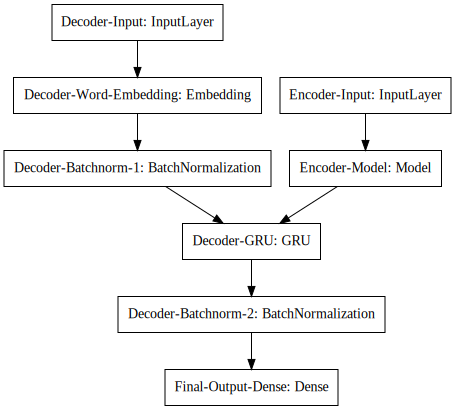

In [ ]:
from seq2seq_utils import viz_model_architecture
seq2seq_Model.summary()
viz_model_architecture(seq2seq_Model)

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 7
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 158 samples, validate on 22 samples
Epoch 1/7



158/158 [==============================] - 4s 27ms/step - loss: 6.8535 - val_loss: 5.3847


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/7
158/158 [==============================] - 1s 9ms/step - loss: 4.7829 - val_loss: 4.9586
Epoch 3/7
158/158 [==============================] - 1s 9ms/step - loss: 4.0784 - val_loss: 4.7196
Epoch 4/7
158/158 [==============================] - 1s 9ms/step - loss: 3.5762 - val_loss: 4.5855
Epoch 5/7
158/158 [==============================] - 1s 9ms/step - loss: 3.1822 - val_loss: 4.5152
Epoch 6/7
158/158 [==============================] - 1s 9ms/step - loss: 2.8666 - val_loss: 4.4667
Epoch 7/7
158/158 [==============================] - 1s 9ms/step - loss: 2.5371 - val_loss: 4.4391


In [ ]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [ ]:
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [ ]:
# this method displays the predictions on random rows of the holdout set
seq2seq_inf.demo_model_predictions(n=50, issue_df=testdf)



============== Example # 6 =================

"https://github.com/Baystation12/Baystation12/issues/16021"
Issue Body:
 not intentional behaviour, but is actually pretty cool thing - you can move down on open space with lattice. i think it should stay, but visible message / delay should be added for consistency with ladders imo. 

Original Title:
 climbing down lattices is instant

****** Machine Generated Title (Prediction) ******:
 replace roadmap readme with event


============== Example # 6 =================

"https://github.com/Baystation12/Baystation12/issues/16021"
Issue Body:
 not intentional behaviour, but is actually pretty cool thing - you can move down on open space with lattice. i think it should stay, but visible message / delay should be added for consistency with ladders imo. 

Original Title:
 climbing down lattices is instant

****** Machine Generated Title (Prediction) ******:
 replace roadmap readme with event


============== Example # 3 =================

"https

In [ ]:
# Read All 5M data points
all_data_df = pd.read_csv('/content/drive/My Drive/natural-language-processing/github_issues.csv').sample(n=200)
# Extract the bodies from this dataframe
all_data_bodies = all_data_df['body'].tolist()

In [ ]:
# transform all of the data using the ktext processor
all_data_vectorized = body_pp.transform_parallel(all_data_bodies)

In [ ]:
# save transformed data
with open('all_data_vectorized.dpkl', 'wb') as f:
    dpickle.dump(all_data_vectorized, f)

In [ ]:
%reload_ext autoreload
%autoreload 2
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf_rec = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                    decoder_preprocessor=title_pp,
                                    seq2seq_model=seq2seq_Model)
recsys_annoyobj = seq2seq_inf_rec.prepare_recommender(all_data_vectorized, all_data_df)

/content/seq2seq_utils.py:380: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.nn = AnnoyIndex(f)
100%|██████████| 200/200 [00:00<00:00, 17218.35it/s]


In [ ]:
seq2seq_inf_rec.demo_model_predictions(n=1, issue_df=testdf, threshold=1)



============== Example # 15 =================

"https://github.com/wandersonwhcr/balance/issues/209"
Issue Body:
 com a migração da máquina virtual do vagrant de wheezy para jessie , esquecemos de atualizar as dependências do apt-get , onde este deve capturar os pacotes do repositório específico da distribuição. este erro foi encontrado após verificar que o postgresql não está sendo inicializado junto com o sistema operacional. 

Original Title:
 atualizar dependências do jessie

****** Machine Generated Title (Prediction) ******:
 replace roadmap readme with event

**** Similar Issues (using encoder embedding) ****:



,issue_url,issue_title,body,dist
5016538,"""https://github.com/SvanteAlnas/Test/issues/29""",omna-registration of lwm2m security,<!doctype html><html><head><meta charset= utf-8 /></head><body><table><tr><td>new omna registration request</td><td>2017-12-27 13:14:38 utc</td></tr><tr><td>submitter's name</td><td>test</td></tr><tr><td>defined by</td><td>oma working group</td></tr><tr><td>type of registration</td><td>object</td></tr><tr><td>object name</td><td>lwm2m security</td></tr><tr><td>object description</td><td>test</td></tr><tr><td>link to object</td><td><a href= https://remote.alnas.xyz:8210/oeditor/modownloadzip?...,0.217566
465910,"""https://github.com/Kotlin/kotlinx.coroutines/issues/67""",withtimeoutornull returns null even when it did not timeout itself,"copied from message by @gregschlom at public slack: hey guys. i have an issue with nested withtimeouts. here’s some example code: val channel = channel<int> // this blocks indefinitely if the channel is empty suspend fun nexvalue : int { println waiting for next value return channel.receive } // same as nextvalue , but returns null after the timeout expires suspend fun nextvaluewithtimout t: long : int? { return withtimeoutornull t { nexvalue } } suspend fun longoperation { println starting ...",0.223055
1639854,"""https://github.com/chendaniely/chendaniely.github.io/issues/26""",add a hobbies section,"- photography - snowboarding - s.c.u.b.a - hobbes, the blue heeler mix :dog2:",0.234810


In [ ]:
seq2seq_inf_rec.demo_model_predictions(n=1, issue_df=testdf, threshold=1)



============== Example # 5 =================

"https://github.com/firemodels/smv/issues/207"
Issue Body:
 the sphere used to distinguish hvac vents from regular vents is not always drawn with an appropriate size to large or too small depending on the size of the compartments being modled 

Original Title:
 problem with zone hvac vent display

****** Machine Generated Title (Prediction) ******:
 feature request request a

**** Similar Issues (using encoder embedding) ****:



,issue_url,issue_title,body,dist
1139719,"""https://github.com/beaugunderson/emoji-aware/issues/6""",extract emoji characters,"as discussed here https://twitter.com/notwaldorf/status/841773147296694272 , there might be a use case in this library to add an extract function to get an array of only the emoji characters.",0.352041
1905124,"""https://github.com/shadowsocks/ShadowsocksX-NG/issues/329""",show qrcode for current server not working.,mac os x latest. shadowsocksx-ng latest. show qrcode for current server not working. can't decode the qrcode.,0.373637
4627902,"""https://github.com/OpenAngelArena/Bug-Reports/issues/27""",spectre random tp after duel when haunt is active,"as i got into duel as spectre i used haunt, we won the duel, my haunt was still active and i got tp somewhere random on the map mostly near the arena",0.378080


In [ ]:
# incase you need to reset the rec system
# seq2seq_inf_rec.set_recsys_annoyobj(recsys_annoyobj)
# seq2seq_inf_rec.set_recsys_data(all_data_df)

# save object
recsys_annoyobj.save('recsys_annoyobj.pkl')

True